In [144]:
import os
import glob
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer
import spacy 
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
from flair.data import Sentence
from flair.models import SequenceTagger
from nltk.util import ngrams
from nltk.corpus import stopwords
twtkz = TweetTokenizer()

In [39]:
nlp = spacy.load('en_core_web_lg')
nlp.max_length = nlp.max_length *1.5
f_t = SequenceTagger.load('ner')

def fx(s):
    return s[4:-4]

2022-08-04 16:07:18,073 loading file C:\Users\William\.flair\models\ner-english\4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
2022-08-04 16:07:20,677 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [40]:
books = glob.glob('**/*.txt')
print(books)

['books\\01 - The Fellowship Of The Ring.txt', 'books\\02 - The Two Towers.txt', 'books\\03 - The Return Of The King.txt']


In [41]:
shelf = [{},{},{}]
for i,b in enumerate(books):
    with open(b) as f:
        t =  f.read()
        shelf[i] = {'title':fx(b), 'text': t, 'norm_text':t.lower(),'n_words':len(t), 'n_sents': len(sent_tokenize(t))}
    print(fx(b), "\t--\t", shelf[i]['n_words'], shelf[i]['n_sents'])

s\01 - The Fellowship Of The Ring 	--	 1021113 13407
s\02 - The Two Towers 	--	 834790 12513
s\03 - The Return Of The King 	--	 724043 9139


In [42]:
for i,b in enumerate(shelf):
    t = b['text']
    ss = [Sentence(s, use_tokenizer=True) for s in sent_tokenize(t)]
    x = nlp(b['text'])
    f_t.predict(ss)
    b['entities'] = x.ents
    b['f_ents'] = [e for f in ss for e in f.get_spans('ner')]

In [111]:
distractions = ['orcs','orc','elf','elves','hobbit','hobbits','ring','river','dwarf','dwarves',
                'bree','hill','rose','tree','moon','sun','wild', 'north','south',
                'him','one','old','black','white','grey','west','battle','wind','lady',
                'dark','hand','master','king','lord','will','dead','hope', 'three','green',
                'evil','enemy','eye','took','helm','farewell','shadow','gate','her','ents',
                'snow','need','folk','wonder','stone','she','man','men']
for b in shelf:
    b['characters'] = [e.text.lower() for e in b['entities'] if e.label_ == "PERSON" and e.text.lower() not in distractions]
    b['fchars'] = [e.text.lower() for e in b['f_ents'] if e.tag == "PER" and e.text.lower() not in distractions]
    print(len(b['characters']), len(b['entities']), "|||", len(b['fchars']))

4194 8000 ||| 4891
3584 6234 ||| 4144
3299 6274 ||| 3843


In [112]:
def most_common(adict, n):
    return [(k, adict[k]) for k in sorted(adict, key=adict.get, reverse=True)][:n]

In [145]:
def extract_ngrams(data, st,ed):
    a = [w for w in twtkz.tokenize(data) if w not in string.punctuation and w not in stopwords.words('english')] #word_tokenize normally
    r = []
    for i in range(st,ed+1):
        b = [' '.join(grams) for grams in ngrams(a, i)]
        r = r+ b
    return r

In [123]:
for b in shelf:
    #tmp = {ch:b['text'].lower().count(ch.lower()) for ch in b['characters']}
    #tmp2 = {ch:b['text'].lower().count(ch.lower()) for ch in b['fchars']}
    tn = extract_ngrams(b['norm_text'], 1, 2)
    tmp  = Counter([wd for wd in tn if wd in b['characters']]) 
    tmp2 = Counter([wd for wd in tn if wd in b['fchars']]) 
    b['mcc'] = tmp
    b['fcc'] = tmp2


In [124]:
for b in shelf:
    print(*[c[0][:7] for c in most_common(b['mcc'],20)],sep='\t')
    print(*[c[1] for c in most_common(b['mcc'],20)],sep='\t')
    print()

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	gollum	sauron	baggins	saruman	butterb	lórien	isildur
1096	463	400	323	227	209	206	204	154	134	126	120	95	68	60	60	52	52	44	41

frodo	sam	gandalf	gollum	aragorn	gimli	pippin	saruman	legolas	merry	sméagol	faramir	treebea	éomer	boromir	rohan	gondor	uglúk	fangorn	orthanc
495	418	339	308	289	192	192	176	175	137	133	133	130	117	88	81	74	55	50	47

sam	frodo	gandalf	pippin	merry	aragorn	faramir	denetho	éomer	rohan	éowyn	gimli	beregon	legolas	minas t	sauron	saruman	cotton	imrahil	nazgûl
459	388	300	281	231	221	158	120	104	95	92	76	72	67	49	47	41	39	34	33



In [125]:
b = most_common(shelf[0]['mcc'],20)#.most_common(20)
b2 = shelf[1]['mcc']
b3 = shelf[2]['mcc']
X = [c[0] for c in b]
y1 = [c[1] for c in b]
y2 = [b2.get(c[0]) if b2.get(c[0]) else 0 for c in b]
y3 = [b3.get(c[0]) if b3.get(c[0]) else 0 for c in b]
print(*X,sep='\t')
print(*y1,sep='\t')
print(*y2,sep='\t')
print(*y3,sep='\t')

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	gollum	sauron	baggins	saruman	butterbur	lórien	isildur
1096	463	400	323	227	209	206	204	154	134	126	120	95	68	60	60	52	52	44	41
495	339	418	8	137	192	289	0	88	13	2	192	175	308	34	6	176	0	21	13
388	300	459	32	231	281	221	0	27	33	6	76	67	22	47	9	41	21	9	15


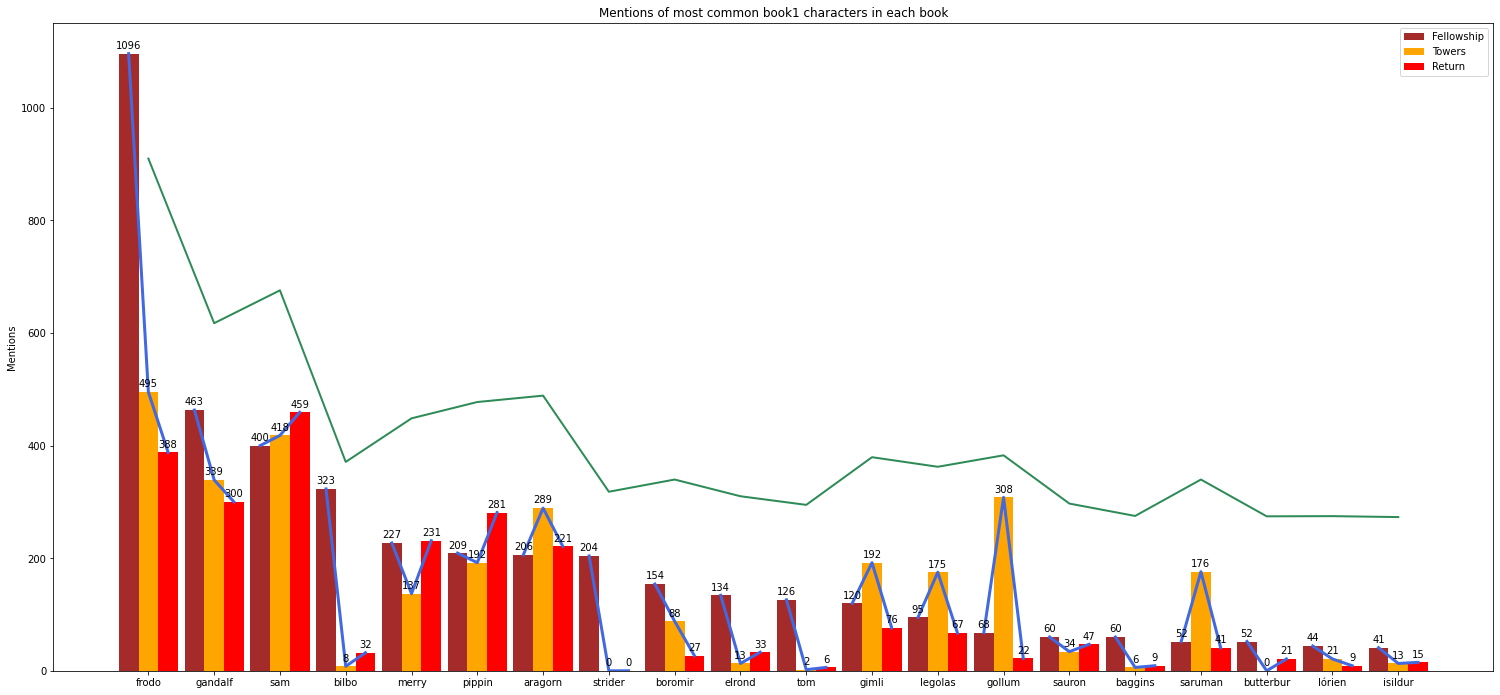

In [126]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
w = 1.5
xa = np.arange(len(X)) *5
b1b = ax.bar(xa - w,    y1, color = 'brown', width = w, label='Fellowship')
b2b = ax.bar(xa + 0.0,  y2, color = 'orange', width = w, label='Towers')
b3b = ax.bar(xa + w,    y3, color = 'red', width = w, label ='Return')
ax.set_ylabel('Mentions')
ax.set_title('Mentions of most common book1 characters in each book')
ax.set_xticks(xa, X)
ax.legend()

ax.bar_label(b1b, padding=3)
ax.bar_label(b2b, padding=3)
ax.bar_label(b3b, padding=3)

fig.set_size_inches(20, 9, forward=True)
nb = []
for j,i in enumerate(xa):
    tmp = [y1[j], y2[j],y3[j]]
    nb.append(sum(tmp)/len(tmp))
    plt.plot([i-w,i, i+w], tmp, '-',c='royalblue', linewidth=3)
plt.plot(xa, np.array(nb) +250, '-', c='seagreen', linewidth=2)

plt.show()

In [127]:
for b in shelf:
    print(*[c[0][:7] for c in most_common(b['fcc'],20)],sep='\t')
    print(*[c[1] for c in most_common(b['fcc'],20)],sep='\t')
    print()

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	rivende	moria	gollum	mordor	sauron	baggins	saruman
1096	463	400	323	227	209	206	204	154	134	126	120	95	86	74	68	66	60	60	52

frodo	sam	gandalf	gollum	aragorn	gimli	pippin	saruman	legolas	himself	merry	sméagol	faramir	treebea	théoden	éomer	isengar	preciou	boromir	sword
495	418	339	308	289	192	192	176	175	142	137	133	133	130	125	117	112	96	88	85

sam	frodo	gandalf	pippin	merry	aragorn	faramir	gondor	denetho	éomer	rohan	théoden	éowyn	mordor	gimli	beregon	legolas	tall	minas t	forth
459	388	300	281	231	221	158	151	120	104	95	92	92	91	76	72	67	62	49	48



In [128]:
b = most_common(shelf[0]['fcc'],20)#.most_common(20)
b2 = shelf[1]['fcc']
b3 = shelf[2]['fcc']
X = [c[0] for c in b]
y1 = [c[1] for c in b]
y2 = [b2.get(c[0]) if b2.get(c[0]) else 0 for c in b]
y3 = [b3.get(c[0]) if b3.get(c[0]) else 0 for c in b]
print(*X,sep='\t')
print(*y1,sep='\t')
print(*y2,sep='\t')
print(*y3,sep='\t')

frodo	gandalf	sam	bilbo	merry	pippin	aragorn	strider	boromir	elrond	tom	gimli	legolas	rivendell	moria	gollum	mordor	sauron	baggins	saruman
1096	463	400	323	227	209	206	204	154	134	126	120	95	86	74	68	66	60	60	52
495	339	418	8	137	192	289	12	88	13	2	192	175	16	14	308	69	34	6	176
388	300	459	32	231	281	221	10	27	33	6	76	67	16	0	22	91	47	9	41


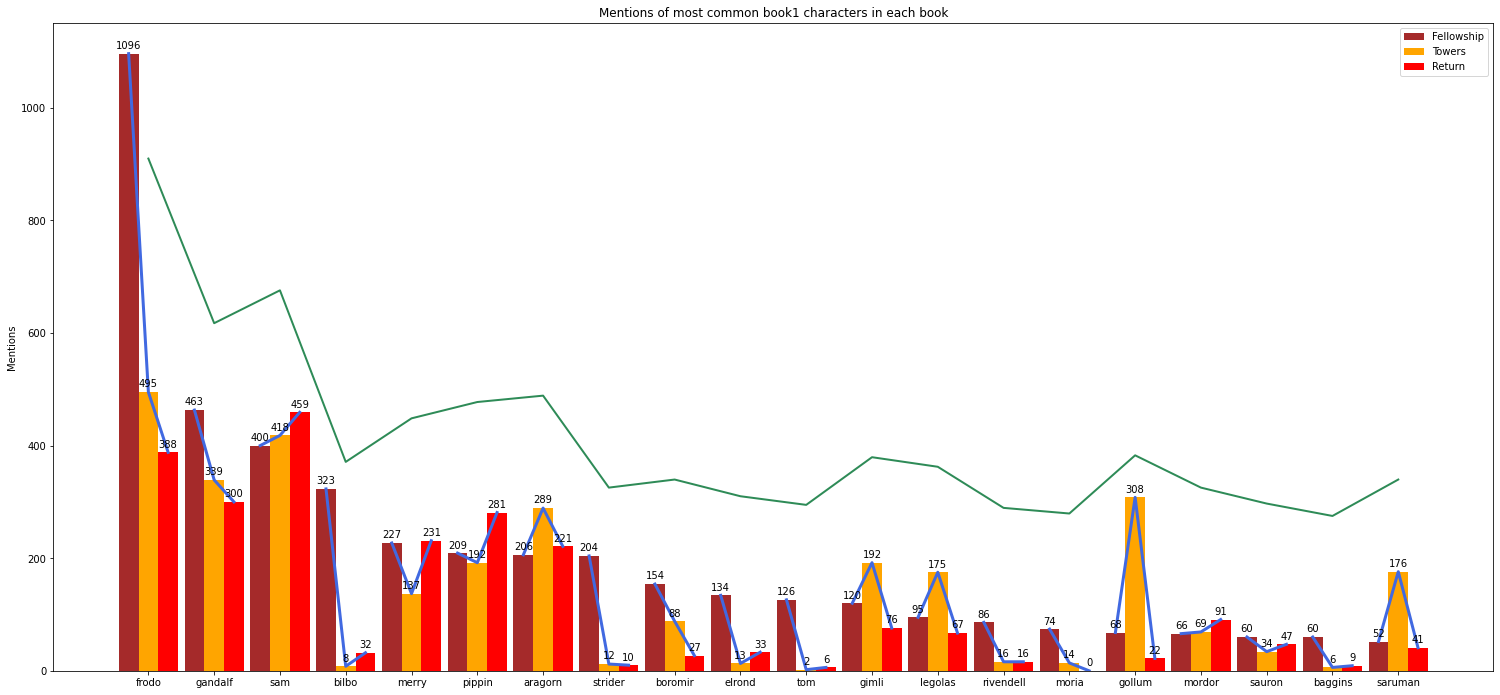

In [129]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
w = 1.5
xa = np.arange(len(X)) *5
b1b = ax.bar(xa - w,    y1, color = 'brown', width = w, label='Fellowship')
b2b = ax.bar(xa + 0.0,  y2, color = 'orange', width = w, label='Towers')
b3b = ax.bar(xa + w,    y3, color = 'red', width = w, label ='Return')
ax.set_ylabel('Mentions')
ax.set_title('Mentions of most common book1 characters in each book')
ax.set_xticks(xa, X)
ax.legend()

ax.bar_label(b1b, padding=3)
ax.bar_label(b2b, padding=3)
ax.bar_label(b3b, padding=3)

fig.set_size_inches(20, 9, forward=True)
nb = []
for j,i in enumerate(xa):
    tmp = [y1[j], y2[j],y3[j]]
    nb.append(sum(tmp)/len(tmp))
    plt.plot([i-w,i, i+w], tmp, '-',c='royalblue', linewidth=3)
plt.plot(xa, np.array(nb) +250, '-', c='seagreen', linewidth=2)

plt.show()

In [146]:
for b in shelf:
    wt = extract_ngrams(b['norm_text'],2, 3)
    cd = Counter(wt)
    b['three_count'] = cd
    print(*b['three_count'].most_common(10))    

('said frodo', 220) ('said gandalf', 135) ('could see', 67) ('said aragorn', 65) ('said sam', 62) ('said merry', 59) ('long ago', 55) ('bag end', 55) ('said pippin', 55) ('let us', 51)
('said frodo', 136) ('said aragorn', 127) ('said gandalf', 120) ('said gimli', 91) ('said sam', 86) ('said legolas', 79) ('said faramir', 72) ('far away', 65) ('let us', 64) ('could see', 60)
('said gandalf', 94) ('mr frodo', 77) ('said frodo', 77) ('said sam', 75) ('said pippin', 70) ('said aragorn', 55) ('said merry', 54) ('minas tirith', 49) ('far away', 42) ('frodo said', 40)
